In [1]:
import re
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

## Load data

In [2]:
with open('./data/rt-polaritydata/rt-polarity-utf8.pos', 'r') as f:
    raw_positive_sentences = f.readlines()
    raw_positive_sentences = [raw_sentence.replace(' \n', '') for raw_sentence in raw_positive_sentences]

In [3]:
with open('./data/rt-polaritydata/rt-polarity-utf8.neg', 'r') as f:
    raw_negative_sentences = f.readlines()
    raw_negative_sentences = [raw_sentence.replace(' \n', '') for raw_sentence in raw_negative_sentences]

## Pre-processings

In [4]:
def _string_cleaner(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [5]:
raw_positive_sentences = [_string_cleaner(sentence) for sentence in raw_positive_sentences]
raw_negative_sentences = [_string_cleaner(sentence) for sentence in raw_negative_sentences]

In [6]:
vocab = ['<unk>']

for sentence in raw_positive_sentences:
    for word in sentence.split(" "):
        if word not in vocab:
            vocab.append(word)

for sentence in raw_negative_sentences:
    for word in sentence.split(" "):
        if word not in vocab:
            vocab.append(word)

In [7]:
len(vocab)

18765

In [8]:
positive_sentences = []
negative_sentences = []
positive_labels = []
negative_labels = []
all_sentences = []
all_labels = []
sentence_length = 0

for sentence in raw_positive_sentences:
    s = []
    for word in sentence.split(" "):
        s.append(vocab.index(word))
    positive_sentences.append(s)
    positive_labels.append(1)
    all_sentences.append(s)
    all_labels.append(1)

for sentence in raw_negative_sentences:
    s = []
    for word in sentence.split(" "):
        s.append(vocab.index(word))
    negative_sentences.append(s)
    negative_labels.append(0)
    all_sentences.append(s)
    all_labels.append(0)
    
for sentence in positive_sentences:
    if sentence_length < len(sentence):
        sentence_length = len(sentence)
        
for sentence in negative_sentences:
    if sentence_length < len(sentence):
        sentence_length = len(sentence)

In [9]:
print(positive_sentences[0])
print(raw_positive_sentences[0])
print(sentence_length)

[1, 2, 3, 4, 5, 6, 1, 7, 8, 9, 10, 11, 12, 13, 14, 9, 15, 5, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
the rock is destined to be the 21st century 's new conan and that he 's going to make a splash even greater than arnold schwarzenegger , jean claud van damme or steven segal
56


In [10]:
def paddinger(sentence_list, sentence_length):
    for sentence in sentence_list:
        if len(sentence) != sentence_length:
            padding_list = [0 for _ in range(0, sentence_length - len(sentence))]
            sentence.extend(padding_list)
    return sentence_list

In [11]:
positive_sentences = paddinger(positive_sentences, sentence_length)
negative_sentences = paddinger(negative_sentences, sentence_length)
all_sentences = paddinger(all_sentences, sentence_length)

In [12]:
index_list = [i for i in range(0, len(all_sentences))]

random.seed(10)
random.shuffle(index_list)

shuffled_sentence = []
shuffled_labels = []
for index in index_list:
    shuffled_sentence.append(all_sentences[index])
    shuffled_labels.append(all_labels[index])

In [13]:
train_data = np.array(shuffled_sentence)
train_label = np.array(shuffled_labels)
print("data: {}, label: {}".format(len(train_data), len(train_label)))

data: 10662, label: 10662


## Word enbeddings

In [14]:
embedding_dim = 128
vocab_size = len(vocab)

model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=sentence_length),
    layers.GRU(units=32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    layers.GRU(units=32, dropout=0.2, recurrent_dropout=0.2),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

W0610 14:30:30.774768 4600812992 deprecation.py:506] From /Users/mitsuhiro/anaconda3/envs/tf-2.0/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 56, 128)           2401920   
_________________________________________________________________
unified_gru (UnifiedGRU)     (None, 56, 32)            15552     
_________________________________________________________________
unified_gru_1 (UnifiedGRU)   (None, 32)                6336      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 2,423,841
Trainable params: 2,423,841
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, train_label, epochs=30, batch_size=256, validation_split=0.01)

Train on 10555 samples, validate on 107 samples
Epoch 1/30
10555/10555 [==============================] - 11s 1ms/sample - loss: 0.6935 - accuracy: 0.4970 - val_loss: 0.6931 - val_accuracy: 0.5047
Epoch 2/30
10555/10555 [==============================] - 8s 801us/sample - loss: 0.6938 - accuracy: 0.4923 - val_loss: 0.6932 - val_accuracy: 0.4953
Epoch 3/30
10555/10555 [==============================] - 9s 845us/sample - loss: 0.6934 - accuracy: 0.4941 - val_loss: 0.6932 - val_accuracy: 0.4953
Epoch 4/30
10555/10555 [==============================] - 11s 997us/sample - loss: 0.6934 - accuracy: 0.4948 - val_loss: 0.6931 - val_accuracy: 0.5047
Epoch 5/30
10555/10555 [==============================] - 9s 866us/sample - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6936 - val_accuracy: 0.4953
Epoch 6/30
10555/10555 [==============================] - 10s 933us/sample - loss: 0.6933 - accuracy: 0.4964 - val_loss: 0.6931 - val_accuracy: 0.5047
Epoch 7/30
10555/10555 [===========================

In [16]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(18765, 128)


In [17]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(vocab_size):
    word = vocab[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

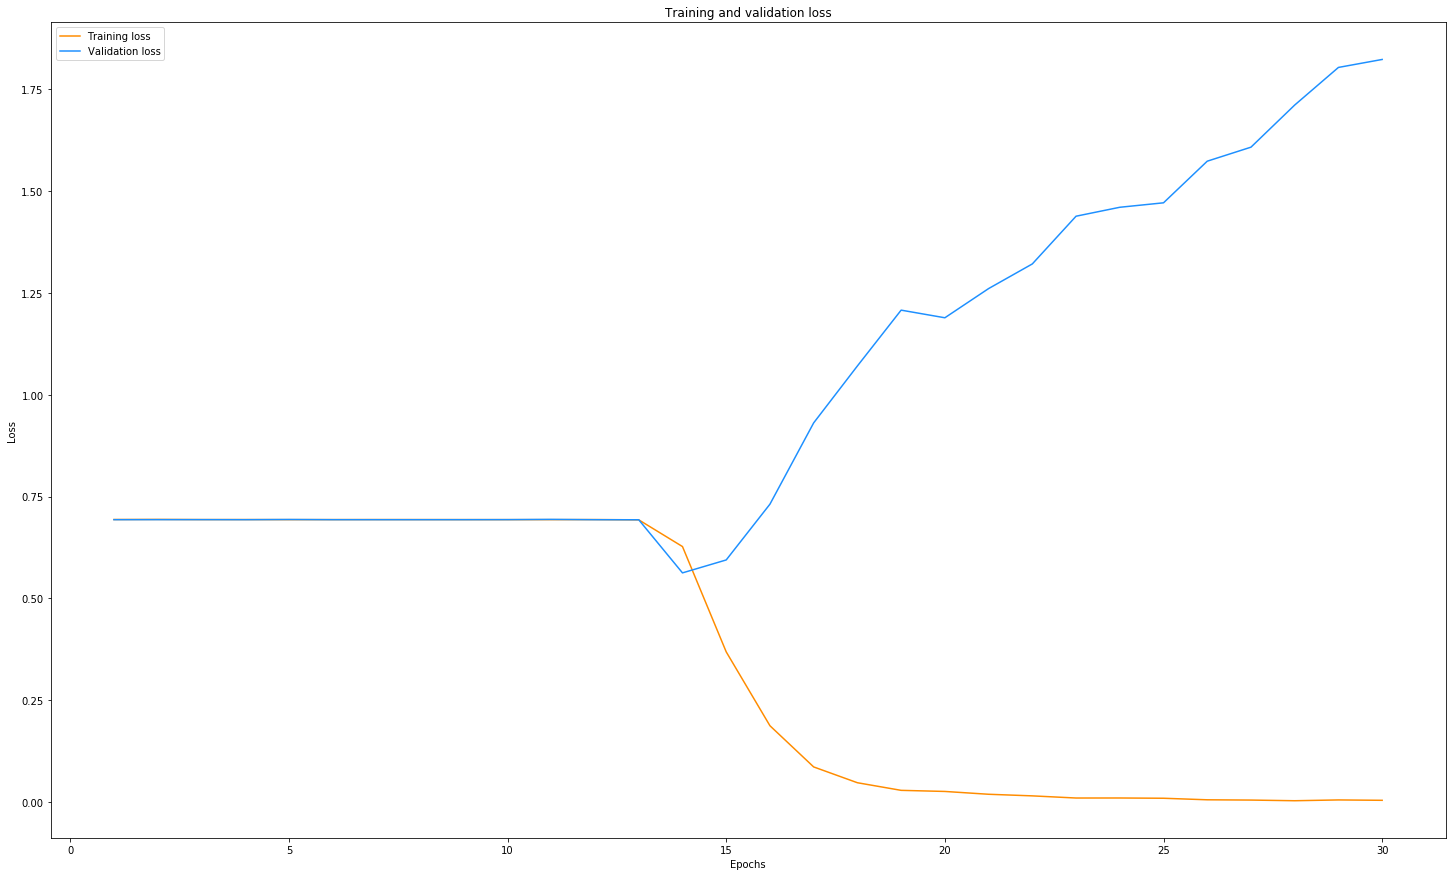

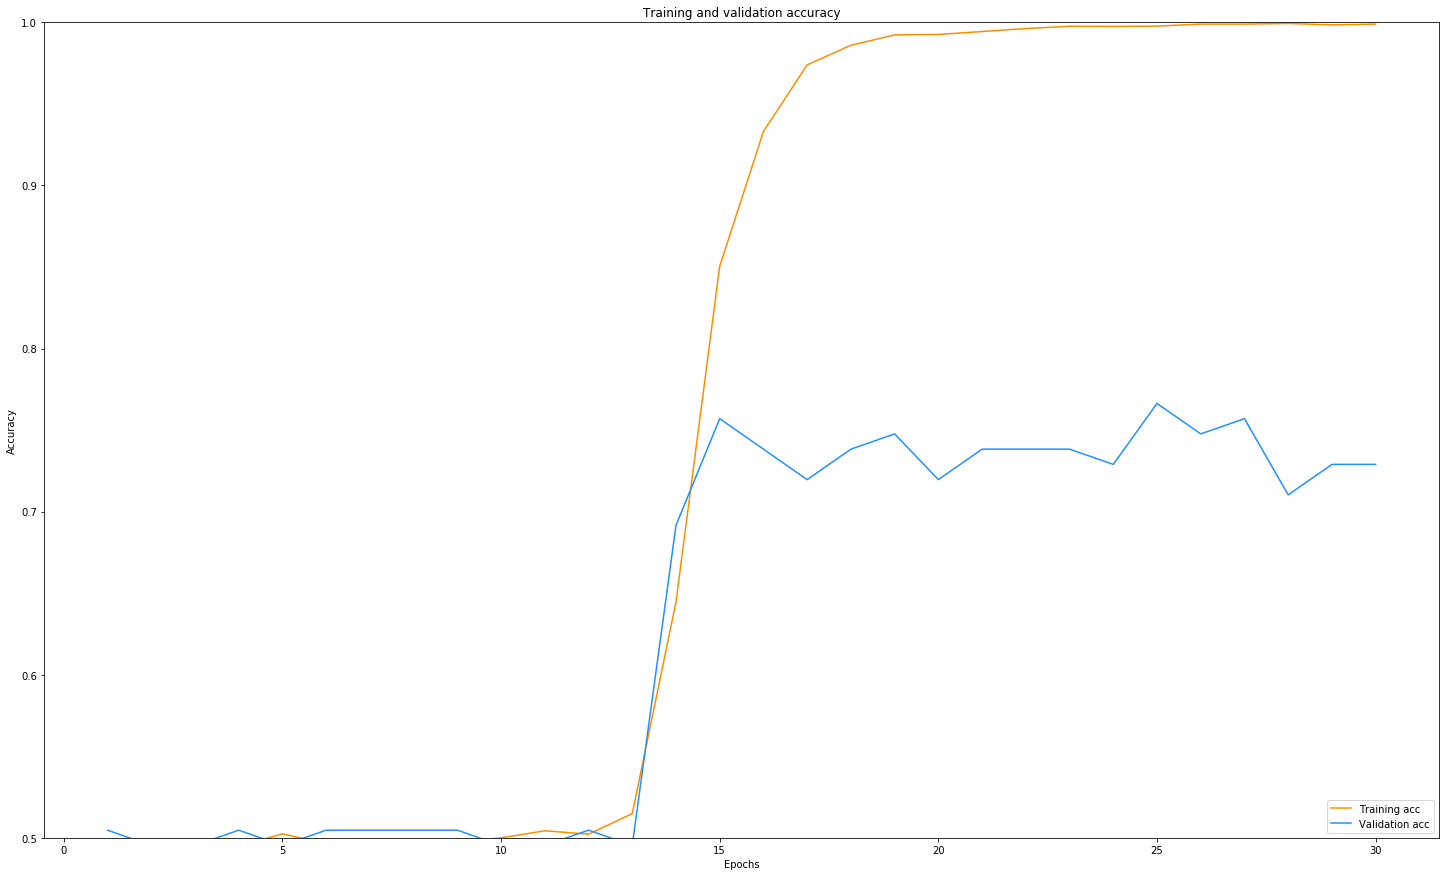

In [18]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(25, 15), facecolor="white")
plt.plot(epochs, loss, 'b', label='Training loss', color="darkorange")
plt.plot(epochs, val_loss, 'b', label='Validation loss', color="dodgerblue")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(25, 15), facecolor="white")
plt.plot(epochs, acc, 'b', label='Training acc', color="darkorange")
plt.plot(epochs, val_acc, 'b', label='Validation acc', color="dodgerblue")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()